In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 25.0 MB/s 
     |████████████████████████████████| 258 kB 25.6 MB/s 
     |████████████████████████████████| 1.8 MB 62.0 MB/s 
     |████████████████████████████████| 103 kB 63.2 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 3
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
# data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


# split fold

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = pd.concat([
    recall_knn(data[data["set"]==0], CFG.num_neighbors), 
    recall_knn(data[data["set"]==1], CFG.num_neighbors), 
])

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
Num of unique id: 1138812
Num of train data: 27845634
Pos rate: 0.07226924694909083
                        id          match_id     kdist  kneighbors  \
12299377  E_883777708f71da  E_33ea7f04531bd7       NaN         NaN   
4195836   E_5e3c71fb930ea6  E_54b8bfe1c934ea  0.002734         7.0   
8962874   E_bd6292e4baccaa  E_95bb2eee990768  0.031115        15.0   
4811078   E_7327265b371d71  E_d201d19b2de723  0.003855         8.0   
1988183   E_7db1cc78769638  E_5a6cf841696117  0.004733         3.0   

         point_of_interest  fold  kdist_country  kneighbors_country  label  
12299377  P_6d390ddcd8bbd3   1.0       0.001172                 5.0      0  
4195836   P_fe8230fd4bc3ac   2.0       0.001349                 7.0      0  
8962874   P_cb885756646a76   2.0       0.026204                15.0      0  
4811078   P_0b90a0e5d39488   0.0       0.003854                 9.0      0  
1988183   P_d5e6310447a643   1.0       0.004016                 3.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9225762918657351


# model learning

In [ ]:
data = data.set_index('id')
# train_data = add_features(train_data)

In [ ]:
train_data['kdist_diff'] = (train_data['kdist'] - train_data['kdist_country']) /\
                            train_data['kdist_country']
train_data['kneighbors_mean'] = train_data[['kneighbors', 'kneighbors_country']].mean(axis = 1)

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        print(f"== fold {i} ==")
        trn_idx = folds==(i-i)%CFG.num_split
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        X_train = add_features(X_train)
        X_valid = add_features(X_valid)
        X_train = X_train[features]
        X_valid = X_valid[features]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

        del X_train, X_valid
        gc.collect()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.048641
[100]	valid_0's binary_logloss: 0.0461229
[150]	valid_0's binary_logloss: 0.0447428
[200]	valid_0's binary_logloss: 0.0436977
[250]	valid_0's binary_logloss: 0.0428286
[300]	valid_0's binary_logloss: 0.0420281
[350]	valid_0's binary_logloss: 0.0412647
[400]	valid_0's binary_logloss: 0.0406356
[450]	valid_0's binary_logloss: 0.0400013
[500]	valid_0's binary_logloss: 0.0394189
[550]	valid_0's binary_logloss: 0.0388887
[600]	valid_0's binary_logloss: 0.0383334
[650]	valid_0's binary_logloss: 0.0377905
[700]	valid_0's binary_logloss: 0.0372939
[750]	valid_0's binary_logloss: 0.0368741
[800]	valid_0's binary_logloss: 0.0364121
[850]	valid_0's binary_logloss: 0.0360042
[900]	valid_0's binary_logloss: 0.03553
[950]	valid_0's binary_logloss: 0.0350984
[1000]	valid_0's binary_logloss: 0.0346826
[1050]	valid_0's binary_logloss: 0.0343306
[1100]	valid_0's binary_logloss: 0.0339604
[1150]	valid_0's binary_logloss: 0.0336147
[1200]	valid_0's binary_logloss: 0

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0504099
[100]	valid_0's binary_logloss: 0.048803
[150]	valid_0's binary_logloss: 0.0483135
[200]	valid_0's binary_logloss: 0.0479407
[250]	valid_0's binary_logloss: 0.0477137
[300]	valid_0's binary_logloss: 0.0475322
[350]	valid_0's binary_logloss: 0.0473297
[400]	valid_0's binary_logloss: 0.0472349
[450]	valid_0's binary_logloss: 0.0471197
[500]	valid_0's binary_logloss: 0.0470322
[550]	valid_0's binary_logloss: 0.0469753
[600]	valid_0's binary_logloss: 0.0468582
[650]	valid_0's binary_logloss: 0.0467946

== fold 2 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0507643
[100]	valid_0's binary_logloss: 0.0492424
[150]	valid_0's binary_logloss: 0.0487877
[200]	valid_0's binary_logloss: 0.0484248
[250]	valid_0's binary_logloss: 0.048216
[300]	valid_0's binary_logloss: 0.04807
[350]	valid_0's binary_logloss: 0.0478819
[400]	valid_0's binary_logloss: 0.047802
[450]	valid_0's binary_logloss: 0.0477078
[500]	valid_0's binary_logloss: 0.0476419
[550]	valid_0's binary_logloss: 0.0476044
[600]	valid_0's binary_logloss: 0.0474995
[650]	valid_0's binary_logloss: 0.047459
[700]	valid_0's binary_logloss: 0.0474258

CV-accuracy: 0.9897110261522507


In [ ]:
train_data["pred"] = oof[:, -1]

In [ ]:
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']

#Check Feature Importances

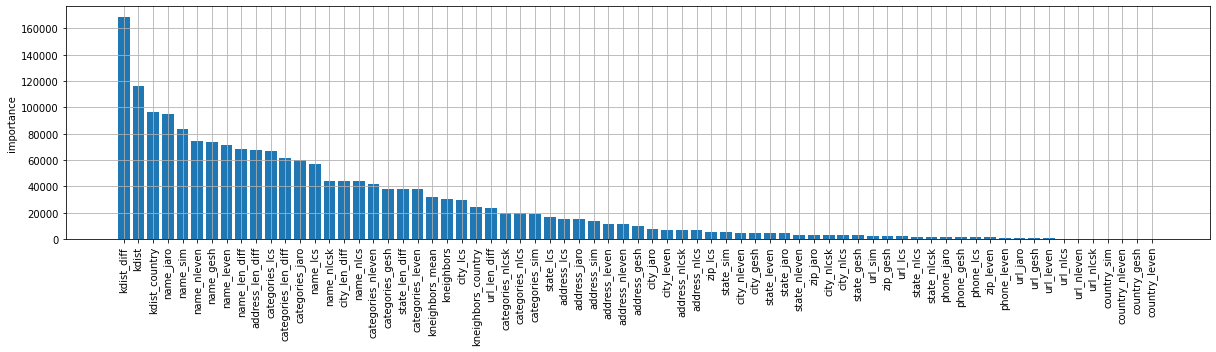

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 30.1 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 210 kB 69.2 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 58.4 MB/s 
     |████████████████████████████████| 146 kB 72.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ff25f269ded7a32a6224b6622a84383ec5f84e334e3a958e17fcbe43309b1e4c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    train_pred_df = train_pred_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    train_pred_df['matches'] = train_pred_df['match_id'].apply(lambda x: ' '.join(set(x)))
    train_pred_df = post_process(train_pred_df)
    score = get_score(train_pred_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-21 04:09:19,775] A new study created in memory with name: no-name-2f182571-9310-469b-8555-b84583fa1a78


CV: 0.847929


[I 2022-05-21 04:09:57,804] Trial 0 finished with value: 0.8479291168247916 and parameters: {'threshold': 0.3930947110924591}. Best is trial 0 with value: 0.8479291168247916.
[I 2022-05-21 04:10:29,577] Trial 1 finished with value: 0.8484390034712274 and parameters: {'threshold': 0.7509579216687419}. Best is trial 1 with value: 0.8484390034712274.


CV: 0.848439


[I 2022-05-21 04:11:00,507] Trial 2 finished with value: 0.8539092293671114 and parameters: {'threshold': 0.5638377980120334}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853909


[I 2022-05-21 04:11:31,492] Trial 3 finished with value: 0.8421547336549481 and parameters: {'threshold': 0.8160669071118237}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.842155


[I 2022-05-21 04:12:02,374] Trial 4 finished with value: 0.8521423002078528 and parameters: {'threshold': 0.475530383326381}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.852142


[I 2022-05-21 04:12:34,213] Trial 5 finished with value: 0.8468801816860628 and parameters: {'threshold': 0.3781575475546204}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.846880


[I 2022-05-21 04:13:06,741] Trial 6 finished with value: 0.850956737309194 and parameters: {'threshold': 0.44712759233857335}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.850957


[I 2022-05-21 04:13:36,809] Trial 7 finished with value: 0.8363150818271207 and parameters: {'threshold': 0.8543975167550821}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.836315


[I 2022-05-21 04:14:12,907] Trial 8 finished with value: 0.6897318631221903 and parameters: {'threshold': 0.026803257342196796}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.689732


[I 2022-05-21 04:14:47,681] Trial 9 finished with value: 0.8266640956038803 and parameters: {'threshold': 0.22000938481778387}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.826664


[I 2022-05-21 04:15:18,092] Trial 10 finished with value: 0.8531807781354851 and parameters: {'threshold': 0.6474540310215957}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853181


[I 2022-05-21 04:15:49,502] Trial 11 finished with value: 0.8530253317889805 and parameters: {'threshold': 0.6548617657938989}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853025


[I 2022-05-21 04:16:21,022] Trial 12 finished with value: 0.853169873022738 and parameters: {'threshold': 0.648145928970906}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853170


[I 2022-05-21 04:16:51,836] Trial 13 finished with value: 0.8538487879731849 and parameters: {'threshold': 0.6094296761928071}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853849


[I 2022-05-21 04:17:24,450] Trial 14 finished with value: 0.8313395177969993 and parameters: {'threshold': 0.24450225115240548}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.831340


[I 2022-05-21 04:17:55,937] Trial 15 finished with value: 0.8538921624482391 and parameters: {'threshold': 0.5593776304586143}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853892


[I 2022-05-21 04:18:26,476] Trial 16 finished with value: 0.8236077837019466 and parameters: {'threshold': 0.907378279634378}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.823608


[I 2022-05-21 04:18:59,928] Trial 17 finished with value: 0.8536655405616915 and parameters: {'threshold': 0.538927410435629}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853666


[I 2022-05-21 04:19:30,736] Trial 18 finished with value: 0.7957825605640332 and parameters: {'threshold': 0.9645640879579602}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.795783


[I 2022-05-21 04:20:02,379] Trial 19 finished with value: 0.8369890049155007 and parameters: {'threshold': 0.2807904229785011}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.836989


[I 2022-05-21 04:20:35,693] Trial 20 finished with value: 0.7872349106119461 and parameters: {'threshold': 0.10450250025937674}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.787235


[I 2022-05-21 04:21:07,314] Trial 21 finished with value: 0.8539082723270149 and parameters: {'threshold': 0.570235350900395}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853908


[I 2022-05-21 04:21:39,142] Trial 22 finished with value: 0.8538020651049718 and parameters: {'threshold': 0.5465070742716399}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853802


[I 2022-05-21 04:22:09,524] Trial 23 finished with value: 0.8503344218346311 and parameters: {'threshold': 0.7197937015127179}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.850334
CV: 0.843311


[I 2022-05-21 04:22:41,781] Trial 24 finished with value: 0.8433107974736618 and parameters: {'threshold': 0.33553231930070937}. Best is trial 2 with value: 0.8539092293671114.
[I 2022-05-21 04:23:14,087] Trial 25 finished with value: 0.8535170772712921 and parameters: {'threshold': 0.5279650854142578}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.853517


[I 2022-05-21 04:23:46,322] Trial 26 finished with value: 0.8483863796864689 and parameters: {'threshold': 0.751580627770522}. Best is trial 2 with value: 0.8539092293671114.


CV: 0.848386


[I 2022-05-21 04:24:16,978] Trial 27 finished with value: 0.8539683342453958 and parameters: {'threshold': 0.5803452946595239}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853968


[I 2022-05-21 04:24:48,977] Trial 28 finished with value: 0.8519984667728637 and parameters: {'threshold': 0.47127557548393995}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.851998


[I 2022-05-21 04:25:20,028] Trial 29 finished with value: 0.8506911857656322 and parameters: {'threshold': 0.44096123499539264}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.850691


[I 2022-05-21 04:25:51,420] Trial 30 finished with value: 0.853868147219278 and parameters: {'threshold': 0.5992831559202745}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853868


[I 2022-05-21 04:26:22,936] Trial 31 finished with value: 0.8539586045444387 and parameters: {'threshold': 0.584105491431862}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853959


[I 2022-05-21 04:26:54,334] Trial 32 finished with value: 0.8506598650161111 and parameters: {'threshold': 0.7135140616117405}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.850660


[I 2022-05-21 04:27:27,094] Trial 33 finished with value: 0.8483743754468995 and parameters: {'threshold': 0.39968720529417207}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.848374


[I 2022-05-21 04:27:57,438] Trial 34 finished with value: 0.8463033889539825 and parameters: {'threshold': 0.7771759990877409}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.846303


[I 2022-05-21 04:28:28,646] Trial 35 finished with value: 0.8516745045821396 and parameters: {'threshold': 0.6902777252035746}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.851675


[I 2022-05-21 04:28:59,266] Trial 36 finished with value: 0.8539405058187666 and parameters: {'threshold': 0.5828837828946873}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853941


[I 2022-05-21 04:29:31,049] Trial 37 finished with value: 0.8528227822964101 and parameters: {'threshold': 0.4956407700557789}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852823


[I 2022-05-21 04:30:02,200] Trial 38 finished with value: 0.8426102105280884 and parameters: {'threshold': 0.8123675791811653}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.842610


[I 2022-05-21 04:30:33,331] Trial 39 finished with value: 0.8495306132734675 and parameters: {'threshold': 0.4190689859352219}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.849531


[I 2022-05-21 04:31:06,692] Trial 40 finished with value: 0.8453875840124232 and parameters: {'threshold': 0.3590896848985046}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.845388


[I 2022-05-21 04:31:37,214] Trial 41 finished with value: 0.8539193628945047 and parameters: {'threshold': 0.5926105423929678}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853919


[I 2022-05-21 04:32:08,639] Trial 42 finished with value: 0.8537269651812176 and parameters: {'threshold': 0.6183074611692775}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853727
CV: 0.852722


[I 2022-05-21 04:32:40,402] Trial 43 finished with value: 0.8527223607051462 and parameters: {'threshold': 0.4932170774431825}. Best is trial 27 with value: 0.8539683342453958.
[I 2022-05-21 04:33:11,867] Trial 44 finished with value: 0.8522103182441105 and parameters: {'threshold': 0.6764178459470069}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852210


[I 2022-05-21 04:33:42,551] Trial 45 finished with value: 0.853924414881233 and parameters: {'threshold': 0.5907155533007646}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853924


[I 2022-05-21 04:34:13,970] Trial 46 finished with value: 0.8537238930438863 and parameters: {'threshold': 0.6192640568191581}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853724


[I 2022-05-21 04:34:45,458] Trial 47 finished with value: 0.8539606155636361 and parameters: {'threshold': 0.5873104592059697}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853961


[I 2022-05-21 04:35:17,326] Trial 48 finished with value: 0.8534824476337519 and parameters: {'threshold': 0.5255042813740151}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853482


[I 2022-05-21 04:35:48,808] Trial 49 finished with value: 0.8531585814579746 and parameters: {'threshold': 0.6487447500663938}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853159


[I 2022-05-21 04:36:19,590] Trial 50 finished with value: 0.8513665347001681 and parameters: {'threshold': 0.4558042564403719}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.851367


[I 2022-05-21 04:36:51,960] Trial 51 finished with value: 0.8539556710700696 and parameters: {'threshold': 0.5866193859872131}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853956


[I 2022-05-21 04:37:22,535] Trial 52 finished with value: 0.8539505863388797 and parameters: {'threshold': 0.5789468589997034}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853951


[I 2022-05-21 04:37:53,948] Trial 53 finished with value: 0.8520922932432275 and parameters: {'threshold': 0.680164505981453}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852092


[I 2022-05-21 04:38:24,819] Trial 54 finished with value: 0.853517939718294 and parameters: {'threshold': 0.5284994854980151}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853518


[I 2022-05-21 04:38:57,151] Trial 55 finished with value: 0.8539242283498638 and parameters: {'threshold': 0.5656457940676671}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853924


[I 2022-05-21 04:39:28,487] Trial 56 finished with value: 0.8536119382704745 and parameters: {'threshold': 0.6268816326366089}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853612


[I 2022-05-21 04:39:58,718] Trial 57 finished with value: 0.8493086775899651 and parameters: {'threshold': 0.7379040010877524}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.849309


[I 2022-05-21 04:40:30,495] Trial 58 finished with value: 0.852839566211841 and parameters: {'threshold': 0.49592548219950383}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852840


[I 2022-05-21 04:41:01,388] Trial 59 finished with value: 0.8461762678307209 and parameters: {'threshold': 0.7784833235176356}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.846176


[I 2022-05-21 04:41:32,597] Trial 60 finished with value: 0.8530808513965596 and parameters: {'threshold': 0.652918917210536}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853081


[I 2022-05-21 04:42:03,832] Trial 61 finished with value: 0.8539429112342948 and parameters: {'threshold': 0.5780333060480983}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853943


[I 2022-05-21 04:42:35,247] Trial 62 finished with value: 0.8539026256426915 and parameters: {'threshold': 0.567678102366449}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853903


[I 2022-05-21 04:43:08,974] Trial 63 finished with value: 0.8536319237545154 and parameters: {'threshold': 0.5363161778661774}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853632


[I 2022-05-21 04:43:40,380] Trial 64 finished with value: 0.8539230884825213 and parameters: {'threshold': 0.5911971669444315}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853923


[I 2022-05-21 04:44:11,550] Trial 65 finished with value: 0.8516701223174067 and parameters: {'threshold': 0.6906882977918427}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.851670


[I 2022-05-21 04:44:42,834] Trial 66 finished with value: 0.8535409962315966 and parameters: {'threshold': 0.6308175123996598}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853541


[I 2022-05-21 04:45:14,571] Trial 67 finished with value: 0.851862199795703 and parameters: {'threshold': 0.46825745065973867}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.851862


[I 2022-05-21 04:45:46,093] Trial 68 finished with value: 0.8533626054403154 and parameters: {'threshold': 0.5189929803236544}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853363


[I 2022-05-21 04:46:17,386] Trial 69 finished with value: 0.8539335951639455 and parameters: {'threshold': 0.5750818467818889}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853934


[I 2022-05-21 04:46:48,950] Trial 70 finished with value: 0.8507970417504099 and parameters: {'threshold': 0.4431210302864439}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.850797


[I 2022-05-21 04:47:22,036] Trial 71 finished with value: 0.8539026504130525 and parameters: {'threshold': 0.5685990255922092}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853903


[I 2022-05-21 04:47:53,351] Trial 72 finished with value: 0.8539201010490671 and parameters: {'threshold': 0.5915082361417767}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853920


[I 2022-05-21 04:48:24,658] Trial 73 finished with value: 0.8538646029624782 and parameters: {'threshold': 0.5525414429795307}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853865


[I 2022-05-21 04:48:56,142] Trial 74 finished with value: 0.8529898854044022 and parameters: {'threshold': 0.5022453386035448}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852990


[I 2022-05-21 04:49:27,179] Trial 75 finished with value: 0.8506651996719024 and parameters: {'threshold': 0.713382831955464}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.850665


[I 2022-05-21 04:49:58,328] Trial 76 finished with value: 0.8529223446643703 and parameters: {'threshold': 0.6587528402658063}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852922


[I 2022-05-21 04:50:29,648] Trial 77 finished with value: 0.8536319758967773 and parameters: {'threshold': 0.6254434757767163}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853632


[I 2022-05-21 04:51:02,388] Trial 78 finished with value: 0.8140107510031541 and parameters: {'threshold': 0.16885618683840953}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.814011
CV: 0.653765


[I 2022-05-21 04:51:39,529] Trial 79 finished with value: 0.6537647473464264 and parameters: {'threshold': 0.018109330054025152}. Best is trial 27 with value: 0.8539683342453958.
[I 2022-05-21 04:52:10,985] Trial 80 finished with value: 0.8539463185248352 and parameters: {'threshold': 0.5825875443739945}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853946


[I 2022-05-21 04:52:42,260] Trial 81 finished with value: 0.853962297196099 and parameters: {'threshold': 0.587167087076708}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853962


[I 2022-05-21 04:53:13,486] Trial 82 finished with value: 0.8538590326151166 and parameters: {'threshold': 0.6071689999496578}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853859


[I 2022-05-21 04:53:44,819] Trial 83 finished with value: 0.8538648658268985 and parameters: {'threshold': 0.5531453096229342}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853865


[I 2022-05-21 04:54:15,934] Trial 84 finished with value: 0.8526096704523487 and parameters: {'threshold': 0.6673396594388319}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852610


[I 2022-05-21 04:54:47,276] Trial 85 finished with value: 0.8534645248194057 and parameters: {'threshold': 0.6342091493583977}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853465


[I 2022-05-21 04:55:19,933] Trial 86 finished with value: 0.8494739340113591 and parameters: {'threshold': 0.41756371601355113}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.849474


[I 2022-05-21 04:55:51,585] Trial 87 finished with value: 0.8532412311228311 and parameters: {'threshold': 0.5109687966811609}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853241


[I 2022-05-21 04:56:22,969] Trial 88 finished with value: 0.8537509304669259 and parameters: {'threshold': 0.5432427886846886}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853751


[I 2022-05-21 04:56:54,536] Trial 89 finished with value: 0.8522032840603119 and parameters: {'threshold': 0.476700523937933}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852203


[I 2022-05-21 04:57:25,672] Trial 90 finished with value: 0.8510901499592469 and parameters: {'threshold': 0.7044675826062119}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.851090


[I 2022-05-21 04:57:56,870] Trial 91 finished with value: 0.8539506343138917 and parameters: {'threshold': 0.5833936908853086}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853951


[I 2022-05-21 04:58:28,200] Trial 92 finished with value: 0.8538547247662873 and parameters: {'threshold': 0.606868096193325}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853855


[I 2022-05-21 04:58:59,420] Trial 93 finished with value: 0.8539631075750302 and parameters: {'threshold': 0.5804925616272043}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853963


[I 2022-05-21 04:59:32,238] Trial 94 finished with value: 0.853941573722356 and parameters: {'threshold': 0.5780687001826704}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853942


[I 2022-05-21 05:00:03,446] Trial 95 finished with value: 0.8532264718035276 and parameters: {'threshold': 0.6448203064195153}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853226


[I 2022-05-21 05:00:34,849] Trial 96 finished with value: 0.8536509973984848 and parameters: {'threshold': 0.5374895531300122}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853651


[I 2022-05-21 05:01:06,256] Trial 97 finished with value: 0.8537865128169441 and parameters: {'threshold': 0.6128064723649662}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853787


[I 2022-05-21 05:01:37,896] Trial 98 finished with value: 0.8525517636838245 and parameters: {'threshold': 0.4862826082971262}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.852552


[I 2022-05-21 05:02:09,422] Trial 99 finished with value: 0.8531772373709421 and parameters: {'threshold': 0.5081502104988471}. Best is trial 27 with value: 0.8539683342453958.


CV: 0.853177


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5803452946595239

In [ ]:
study.best_value

0.8539683342453958

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
train_pred_df = train_pred_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
train_pred_df['matches'] = train_pred_df['match_id'].apply(lambda x: ' '.join(set(x)))
train_pred_df = post_process(train_pred_df)
score = get_score(train_pred_df)
print(f"CV: {score:.6f}")

CV: 0.853968
